In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c, k_B, M_sun, G, m_p
import numpy as np
import numba
import sys

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

### Defining initial profile of surface density $Σ$

$$Σ_{\textrm{int}}=Σ_{\textrm{1au}}\left(\frac{r}{\textrm{1au}}\right)^{-3/2}\textrm{exp}\left(-\frac{r}{r_{\textrm{cut}}}\right)$$

$$Σ_{\textrm{1au}}=1.7\cdot10^{4}\textrm{g}\;\mathrm{cm}^{-2},\quad r_{\textrm{cut}}=30\textrm{au}$$


In [3]:
Σ_1au = 1.7e4 * u.g * u.cm**-2
r_cut = 30 * u.au
def Σ_initial(r):
    return Σ_1au * (r / (1 * u.au))**(-3/2) * np.exp(- r / r_cut)  

In [12]:
r_in = 0.01 # AU
r_out = 1e4 # AU
r = r_in
r_list = [r]
while r < 1e4:
    Δr = np.sqrt(r)
    r = r + Δr
    r_list.append(r)
r_array = np.asarray(r_list)

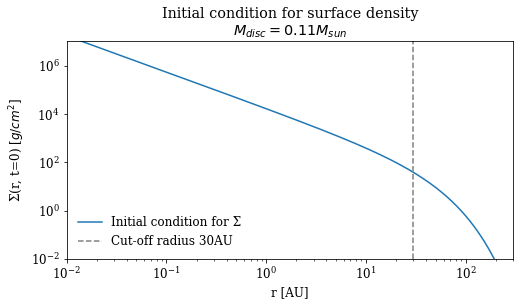

In [22]:
r = r_array * u.au
fig, axs = plt.subplots(figsize = (8,4))
axs.set(xlabel = 'r [AU]', ylabel = 'Σ(r, t=0) [$g/cm^2$]', 
title = 'Initial condition for surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e7), xlim = (0.01, 300))

axs.plot(r, Σ_initial(r), label = 'Initial condition for Σ')
axs.axvline(r_cut.value, label = f'Cut-off radius {r_cut.value:2.0f}AU', ls='--', c='grey')

axs.legend(frameon = False)

### Defining temperature function to later be used to calculate the sound speed $c_s$
$$T^4 = T_{\textrm{req}}^4+T_{\textrm{vis}}^4$$
#### Temperature due to irradiation from the central star, $T_{\textrm{req}}$ (radiation equilibrium): 
$$T_{\textrm{req}}=T_{\textrm{1au}}\left(\frac{r}{\textrm{1au}}\right)^p$$
$$T_{\textrm{1au}}=280\textrm{K},\quad p = -1/2$$

In [6]:
T_1au = 280 * u.K
def T_req(r):
    return T_1au * (r / (1 * u.au))**(-1/2)

### Temperature due to vicous heating $T_\textrm{vis}$:
(Nakamoto and Nakagawa 1994)
$$2σ_\textrm{SB}T_\textrm{vis}^4=\left(\frac{3}{8}τ_\textrm{R} + \frac{1}{2τ_\textrm{p}}\right)F_\textrm{rad}$$
$$F_\textrm{rad}=2σ_\textrm{SB}T_\textrm{surf}^4$$